In [48]:
import os
import tensorflow as tf
import sklearn
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate, Input, Cropping2D
from keras.models import Model
from keras.optimizers import Adam
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from skimage.io import imread
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score

## 1. Read images

In [49]:
TRAIN_IMG_PATH = "./data/mri/"
TRAIN_LBL_PATH = "./data/labels/"

TEST_IMG_PATH = 'banco_dados_SB/test/imagens/'
TEST_LBL_PATH = 'banco_dados_SB/test/classes/'

In [50]:
X_train = [imread(fname=TRAIN_IMG_PATH + img, as_grey=True) for img in os.listdir(TRAIN_IMG_PATH)]
y_train = [imread(fname=TRAIN_LBL_PATH + lbl)[:, :] for lbl in os.listdir(TRAIN_LBL_PATH)]

## Criando Jaccard Validation

In [51]:
K.set_image_data_format('channels_last')
def Dice (y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_true)
    return jaccard_similarity_score(y_true_f, y_pred_f)

### Criando um validation set

In [52]:
X_train = np.asarray(X_train)/255
y_train = np.asarray(y_train)/255

In [53]:
print(X_train.shape)
print(y_train.shape)
# testando o minimo
y_train_vec = np.reshape(y_train,[260,-1])
print(max(y_train_vec[0,:]))

(260, 256, 256)
(260, 256, 256)
1.0


In [54]:
bounds = int(len(X_train)-(np.floor(338*.1)))
print (bounds)
X_test = X_train[bounds:,:,:]
y_test = y_train[bounds:,:,:]
X_train = X_train[:bounds,:,:]
y_train = y_train[:bounds,:,:]
print(X_test.shape,y_test.shape )
print(X_train.shape,y_train.shape )

227
(33, 256, 256) (33, 256, 256)
(227, 256, 256) (227, 256, 256)


## 2. Testing data set

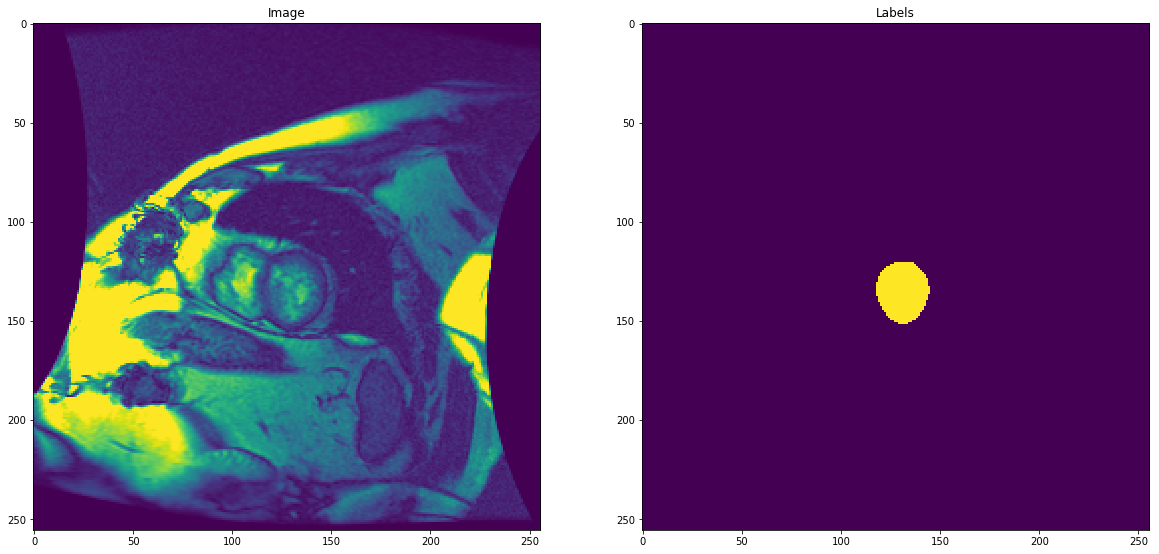

In [55]:
idx = 4

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[idx])
ax[0].set_title('Image')

ax[1].imshow(y_train[idx])
ax[1].set_title('Labels')

plt.show()

## 3. Create CNN model

In [56]:
class Unet_LIS(object):

    def __init__(self, img_rows , img_cols):
        self.img_rows = img_rows
        self.img_cols = img_cols
            
    def get_unet(self):

        inputs = Input((self.img_rows, self.img_cols,1))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)
        
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
        
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8],axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
        
        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9],axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(2, 1, activation = 'sigmoid')(conv9)
        model = Model(input = inputs, output = conv10)

        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [Dice])

        return model

In [57]:
myunet = Unet_LIS(X_train[0].shape[0],X_train[0].shape[1])
model = myunet.get_unet()

C:\Users\Tales\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


ValueError: Expected array-like (array or non-string sequence), got <tf.Tensor 'Reshape:0' shape=(?,) dtype=float32>

In [ ]:
model.summary()

## 4. Prepare data

In [ ]:
# Reshape input images to fit TensorFlow shape pattern
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

#### One-Hot-Encoded para imagens label treinamento

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
# criando vetor unitario para validação
y_train_vec = np.reshape (y_train,[-1])
print (y_train_vec.shape)
print ("min y_train: ",min(y_train_vec))
print ("max y_train: ",max(y_train_vec))
# fazendo o one-hot-encoded
y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
y_train_ohe = y_train_ohe.toarray()
y_train_ohe=np.reshape(y_train_ohe,[227,256,256,2])

#### One-Hot-Encoded para imagens label de teste

In [ ]:
y_teste_vec = np.reshape (y_test,[-1])
print (y_teste_vec.shape)
print ("min y_train: ",min(y_teste_vec))
print ("max y_train: ",max(y_teste_vec))
y_teste_ohe = encoder.fit_transform(y_test.reshape(-1,1))
y_teste_ohe = y_teste_ohe.toarray()
y_teste_ohe=np.reshape(y_teste_ohe,[33,256,256,2])

## 5. Train model

In [ ]:
print(X_train.shape)
print(y_train_ohe.shape)
print(X_test.shape)
print(y_teste_ohe.shape)


In [ ]:
from keras.models import load_model
savings = "./savings_UNet"
if os.path.isdir(savings):
    path_sav = "savings_UNet/"
    model = load_model(path_sav +'U_net.h5')
    print('Rede iniciando de onde parou')

In [ ]:
batch_size = 16
epochs = 1
tbCallBack = keras.callbacks.TensorBoard(log_dir='./GraphUnet', histogram_freq=0,  
          write_graph=True, write_images=True,batch_size=batch_size)

# Monitorando se a função não esta aprendendo mais...
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_teste_ohe),
          callbacks=[tbCallBack,early_stopping])

In [ ]:
if not os.path.isdir('savings_UNet'):
    path_sav = "savings_UNet/"
    os.makedirs(path_sav)
model.save(path_sav +'U_net.h5')

In [ ]:
P_fig = model.predict(X_test, batch_size=batch_size, verbose=1)

## 6. Atribuindo pixel-wise de maior probabilide, um valor

In [ ]:
ch0_arr = np.asarray (P_fig[:,:,:,0])
ch1_arr = np.asarray (P_fig[:,:,:,1])
ch_shape = ch0_arr.shape
print(ch_shape)

In [ ]:
ch0_arr = np.reshape(ch0_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])
ch1_arr = np.reshape(ch1_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])

In [ ]:
im_final = np.zeros(ch0_arr.shape)
for ii in np.arange(len(ch0_arr)):
    if ch0_arr[ii]>ch1_arr[ii] :
        im_final[ii] = 0
    else:
        im_final[ii] = 1
im_final = np.reshape(im_final,ch_shape)

In [ ]:
idx = 6


fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(X_test[idx,:,:,0])
ax[0].set_title('Imagem teste')

ax[1].imshow(im_final[idx,:,:])
ax[1].set_title('Imagem final')

In [ ]:
sess = tf.Session()
writer = tf.summary.FileWriter("Graph")
writer.add_graph (sess.graph)
sess.close()